# Задача сегментации: кластеризация

В данной тетради рассматривается решение задачи сегментации клиентской базы методами кластерного анализа, в частности  алгоритмами иерархической кластеризации. Показаны возможности библиотек Python непосредственно по решению задачи кластеризации, извлечению нужной структуры кластеров и их графического представления.    
Общая схема решения задачи:     
1. Предварительный анализ структуры выборки (чтение из файла, размерность, просто заголовков, просмотр части данных, получение информации о типах данных, преобразование типов, поиск пропусков, заполнение пропусков, стандартизация данных);
2. Кластеризация: алгоритмы иерархической кластеризации, алгоритм k-средних;
3. Анализ результатов кластеризации.

В татради также приводятся сслыки на используемые источники. 

# 1. Структура исходных данных

## 1.1. Чтение исходных данных

Для ознакомления с необходимым материал рекомендую книгу [1, глава 6, стр. 175].     
В рассматриваемом примере исходные данные хранятся в txt-файле, разделенные знаком табуляции.    
Для чтения воспользуемся функцией `.read_table()`.    
В качестве параметров передадим
- `path` -- путь к файлу;
- `encoding` -- исходную кодировку, в которой хранятся данные;
- `sep` -- последовательность символов или регулярное выражение, служащее для разделения полей в строке: ',',';','\t'(знак табуляции), '\s+' -- если поля разделены переменным числом пробелов;
- `nrows` -- количество читаемых строк от начала файла.

Подключаем библиотеку `pandas` и загружаем исходные данные в датафрейм `df`. 

ВАЖНО: В данном случае с целью упрощения и повышения производительности прочитаны только первых 100 строк исходного массива.

In [74]:
import pandas as pd
pd.set_option('display.precision',3)
df=pd.read_table('mobile.txt', encoding='1251', sep='\t', nrows=4000)

## 1.2. Получение предварительной информации о массиве   

Для получения предварительной информации об анализируемом массиве можно воспользоваться следующими возможностями Python    
- Просмотр с помощью свойства `.head()` указанного числа первых строк датафрейма. По умолчанию выводится 5 первых строк датафрейма;
- Размерность датафрейма можно узнать с помощью свойства .shape;
- Просмотр заголовков столбов с помощью свойства .columns;
- Просмотр информации о типах переменных с помощью свойства `.info()`

In [75]:
df.head()

,Код,Возраст,Среднемесячный расход,Средняя продолжительность разговоров,Звонков днем за месяц,Звонков вечером за месяц,Звонков ночью за месяц,Звонки в другие города,Звонки в другие страны,Доля звонков на стационарные телефоны,Количество SMS за месяц
0,0,24,121.54,2.4,12,65,5,0,0,5,56
1,1,51,287.51,1.7,111,109,1,44,0,6,1
2,2,41,113.70,2.1,41,27,0,0,0,1,36
3,3,35,410.23,5.6,47,49,0,0,0,11,23
4,4,26,537.60,4.8,58,77,4,0,0,16,29


ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: С помощью свойства `.tail()` можно просмотреть заданное число последних строк массива. По умолчанию выводится 5 строк 

+ Размерность датафрейма можно узнать с помощью свойства `.shape`    
ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: количество строк датафрейма можно узнать с помощью метода `len()`

In [76]:
df.shape

(4000, 11)

+ Просмотр заголовков столбов с помощью свойства `.columns` 

In [77]:
df.columns

Index(['Код', 'Возраст', 'Среднемесячный расход',
       'Средняя продолжительность разговоров', 'Звонков днем за месяц',
       'Звонков вечером за месяц', 'Звонков ночью за месяц',
       'Звонки в другие города', 'Звонки в другие страны',
       'Доля звонков на стационарные телефоны', 'Количество SMS за месяц'],
      dtype='object')

## 1.3. Аккуратные данные

Аккуратные данные --- данные, пригодные для дальнейшего анализа. Для получения аккуратных данных необходимо разрешить следующие проблемы, связанные с имеющимися данными (список может быть расширен):     
- имена объектов или признаков отличаются от желаемых (требуемых);  
- есть пропущенные данные;
- значения указаны не в тех единицах измерения, которые требуются;
- временной период выборки наблюдений не тот;
- переменные являются категориальными, а требуются количественные;
- присутсвует шум в данных;
- информация неверного типа;
- данные неправильно ориентированы по осям;
- данные неправильно нормализованы;
- данные дублизуются.

## 1.3.1 Поиск и импутация пропущенных наблюдений
- Вывод общей информации о наличие пропусков во всех переменных можно осуществить, воспользовавшись цепочкой методов `.isnull()` и `.sum()`

In [78]:
df.isnull().sum()

Код                                      0
Возраст                                  0
Среднемесячный расход                    0
Средняя продолжительность разговоров     0
Звонков днем за месяц                    0
Звонков вечером за месяц                 0
Звонков ночью за месяц                   0
Звонки в другие города                   0
Звонки в другие страны                   0
Доля звонков на стационарные телефоны    0
Количество SMS за месяц                  0
dtype: int64

## 1.3.2 Типы признаков

Для просмотра информации о типах наблюдаемых признаков у объектов воспользуемся свойством `.info()`

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
Код                                      4000 non-null int64
Возраст                                  4000 non-null int64
Среднемесячный расход                    4000 non-null float64
Средняя продолжительность разговоров     4000 non-null float64
Звонков днем за месяц                    4000 non-null int64
Звонков вечером за месяц                 4000 non-null int64
Звонков ночью за месяц                   4000 non-null int64
Звонки в другие города                   4000 non-null int64
Звонки в другие страны                   4000 non-null int64
Доля звонков на стационарные телефоны    4000 non-null int64
Количество SMS за месяц                  4000 non-null int64
dtypes: float64(2), int64(9)
memory usage: 343.9 KB


## 1.3.3 Генерирование входного массива и нормализация признаков 

In [122]:
X=df.iloc[:,1:].values #копирование значений датафрейма без наблюдения "Код"
X=(X-X.mean(axis=0))/X.std(axis=0) #стандартизация данных
#print(X.mean(axis=0)) #просмотр массива выборочных средних -- они должны быть равны 0 
#print(X.std(axis=0)) # просмотр массива стандартных отклонений --- они должны быть равными 1
#print(X) # просмотр входного массива --- аккуратные данные!!!!

# 2. Кластеризация: агломеративный алгоритм

## 2.1 Реализация разбинения, матрица связей и ее интерпретация, визуализация

Для дополнительного изучения материала рекомендуется воспользоваться ресурсами [2, 3]    
Иерархическая кластеризация реализована в модуле `scipy.cluster.hierarchy`.    
Импортируем из этого модуля методы:    
- `.linkage()` -- выполняет иерархическую (агломеративную) кластеризацию; 
- `.dendrogram()` -- строит дендрограмму;
- `.fcluster()` -- 

Метод `.linkage()` имеет следующую спецификацию `linkage(X[, method, metric, optimal_ordering])`:    
- X -- матрица попарных расстояний или исходных данных (в матрице не должно быть пробелов или категориальных значений)
- method -- правило, по которому будут рассчитываться расстояния между кластерами:    
    - `single`
    - `complete`
    - `average`
    - `weighted`
    - `centroid`
    - `median`
    - `ward`
- metric -- метрика: `braycurtis`, `canberra`, `chebyshev`, `cityblock`, `correlation`, `cosine`, `dice`, `euclidean`, `hamming`, `jaccard`, `jensenshannon`, `kulsinski`, `mahalanobis`, `matching`, `minkowsk`, `rogerstanimoto`, `russellrao`, `seuclidean`, `sokalmichener`, `sokalsneath`, `sqeuclidean`, `yule`.

Результатом выполнения метода `.linkage()` является массив связей кластера. Обозначим его `Z`. Ниже дадим интерпретацию элементам массива `Z`.   

In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np

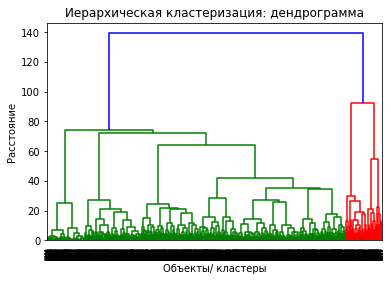

In [85]:
Z = linkage(X, method='ward') 
plt.figure()
plt.title('Иерархическая кластеризация: дендрограмма')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z) #рекомендуется посмотреть и другие параметры этого метода 
plt.savefig('dendrogramma.png', dpi = 300) #сохранить рисунок
plt.show() #отобразить дендрограмму 

In [159]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
Z

array([[ 3419.000,  3697.000,  0.016,  2.000],
       [ 2298.000,  3307.000,  0.016,  2.000],
       [ 1317.000,  3406.000,  0.024,  2.000],
       ...,
       [ 7983.000,  7995.000,  74.160,  3562.000],
       [ 7989.000,  7993.000,  92.775,  438.000],
       [ 7996.000,  7997.000,  139.438,  4000.000]])

Дадим интерпретацию элементам массив связей кластера `Z`. В первом и втором столбцах массива `Z` указаны индексы кластеров (в том числе синглетонов), объединяющих на текущей итерации. В третьем столбце находится расстояние между кластерами. В четвертом столбце индекс нового кластера, показыващий число синглетонов в новом кластере. Например, строка Z[0] содержит следующее `[3419.000,  3697.000,  0.016,  2.000]`. Элементы этой строки показывают, что на первой (напомним, что индексация массивов начинается с 0) итерации алгоритма объединяются кластеры (здесь синглетоны -- кластер, состоящий из одного элемента) с номерами 3419 и 3697, расстояние между кластерами равно 0.016, новому кластеру присвоен номер 2 -- по числу синглетонов в образовавшемся кластере, и т.д.     
Напомним, что в исходном массиве число объектов 4000, проиндексированных от 0 до 3999. Если имеем индексы такие, что $idx \geqslant len(X)$ соответствуют кластерам, которые объединились ранее и находятся в массиве связей кластера в строке $Z[idx-len(X)]$, где $len(X)=3999$.

Итак, построили полное дерево кластеров. Займемся теперь вопросом поиска оптимального разбиения по числу кластеров. Воспользуемся для этого `методом локтя`. 

## 2.2 Оптимальная структура разбиения: метод локтя

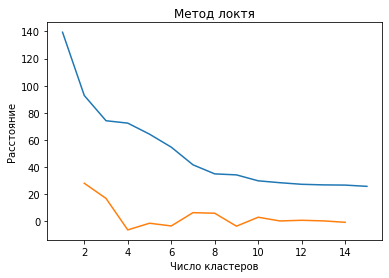

clusters: 2


In [165]:
last = Z[-15:, 2] # в матрице связей берем последние 20 значений расстояний между кластерами 
last_rev = last[::-1] #переписываем в обратном порядке  
idxs = np.arange(1, len(last) + 1,1) #генерируем список начальное значение 1, конечное --- число элементов массива, шаг 1
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.title('Метод локтя')
plt.plot(idxs, last_rev) #отображение графика 

#далее идет расчет вторых разностей, пример взят из [2]  
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

На данном графике показана зависимость расстояния между кластерами от номера шага итерации, на котором два ближайших кластера объединяются в новый --- синия линия.Оранжевая линия показывает, как меняется ускорение --- быстрота изменения расстояния между объединяемыми кластерами. В данном случае оптимальным числом кластеров может считаться 2, 3, 7 или 8. Ориентируясь на поведение функции расстояния, примем в качестве оптимальное разбиения --- разбиение на 8 кластеров. 

## 2.3 Анализ результатов кластеризации: усеченная дендрограмма, выбор кластеров, вывод состава кластеров

Если количество элементов, подлежащих кластеризации велико, то можно отобразить усеченную дендрограмму. Усечение используется для сжатия дендрограммы. Для того, чтобы построить усеченную дендрограмму необходимо в команде `.dendrogram()` использовать режим `truncate_mode` со значением `lastp` или `level`.     
Если `truncate_mode='lastp'`, то отображается `p` последних образовавшихся кластера. В матрице связей $Z$ это соответствует строкам $Z[n-p-2:end]$. По оси абцисс в скобках указывается число объектов, содержащихся в кластерах.

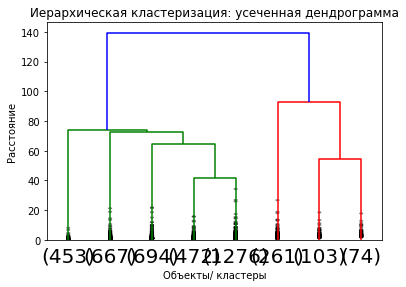

In [164]:
plt.figure()
plt.title('Иерархическая кластеризация: усеченная дендрограмма')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z, 
           truncate_mode = 'lastp', #включен режим показывать последние 'p' кластеров  
           p=8,                     #отобразить последние 8 кластеров 
           leaf_rotation = 0,       #угол поворота надписей по оси  
           leaf_font_size = 20,     #размер шрифта  
           show_contracted = True)  # рисовать черные точки на высотах предыдущих слияний кластеров
plt.savefig('trunc_dendrogramm.png', dpi = 300)
plt.show()

Для выделения некоторого разбиения объектов на кластеры воспользуемся функцией `fcluster()`, которая на основе построенной матрицы связей `Z` выделяет некоторое разбиение на кластеры, исходя из задаваемых пользователем критериев. В качестве критерия можно указать либо максимальное количество кластеров `criterion='maxclust'`, либо расстоние `criterion='distance'`.     
 
В первом случае мы указываем требуемое (желаемое) максимальное число кластеров, т.е. используем критерий `criterion='maxclust'`. На выходе имеем массив с указанием номера кластера, которому принадлежит соответствующий исходный объект 

In [166]:
label=fcluster(Z, 8, criterion='maxclust')
print(label)

[2 3 2 ... 1 4 7]


Для анализа каждого из выделенных кластеров реализуем следующие действия:    
1) добавим в исходный датафрейм новый столбец `Номер кластера`;    
2) в цикле `for` с использоанием механизма группировки датафрейма `groupby` выведем объекты кластеров

In [167]:
df.loc[:,'Номер кластера']=label # добавление нового столбца с метками 
for i, group in df.groupby('Номер кластера'): # вывод элементов каждого кластера  
    print('=' * 10)
    print('cluster {}'.format(i))
    print(group)

cluster 1
       Код  Возраст  Среднемесячный расход  \
7        7       66                  14.52   
15      15       69                  50.40   
19      19       52                  17.69   
20      20       59                  74.88   
46      46       68                  39.00   
...    ...      ...                    ...   
3978  4068       39                  17.64   
3981  4071       34                  18.92   
3982  4072       66                  38.40   
3992  4082       68                  32.64   
3997  4088       64                  77.52   

      Средняя продолжительность разговоров  Звонков днем за месяц  \
7                                      1.1                     10   
15                                     2.1                     15   
19                                     1.8                      7   
20                                     2.4                      9   
46                                     2.5                      9   
...                    

Во втором случае мы указываем расстояние по оси ординат, на котором будем проводить линию среза, т.е. используем критерий `criterion='distance'`. На выходе имеем массив с указанием номера кластера, которому принадлежит соответствующий исходный объект.     
Пусть, например, мы хотим узнать какие кластеры объединились на расстоянии 38. Для наглядности на дендрограмме нарисуем соответствующую линию среза `y=38`.   

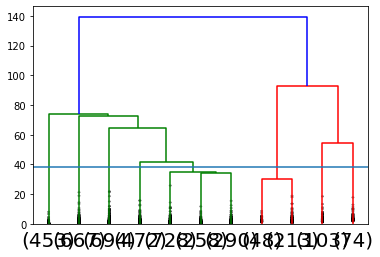

In [61]:
plt.axhline(y=38) #рисуем горизонтальную линию
dendrogram(Z, 
           truncate_mode = 'lastp', #включен режим показывать последние 'p' кластеров  
           p=11,                     #отобразить последние 11 кластеров 
           leaf_rotation = 0,       #угол поворота надписей по оси  
           leaf_font_size = 20,     #размер шрифта  
           show_contracted = True)  # рисовать черные точки на высотах предыдущих слияний кластеров
plt.show()

На рисунке показано, что на этом уровне имеется 8 кластеров. Выделим эти кластеры с использованием функции `fcluster()`, задав критерий расстояния. Имеем

In [183]:
label1=fcluster(Z, 38, criterion='distance')
print(label1)

[2 3 2 4 ... 2 1 4 7]


Видим, что построено распределение исходных элементов на 8 кластеров. Для анализа каждого кластера можно проделать последовательность действий, аналогичную выше рассмотренной.  

ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: Следует заметить, что при использовании значения `distance` количество кластеров уменьшается с ростом расстояния -- значения параметра `t`. ЖЕЛАТЕЛЬНО разместить соответствующий график зависимости.  

In [185]:
counts = np.bincount(label1)
print(counts)

[   0  453  667  694 ... 1276  261  103   74]


# 3. Неиерархическая кластеризация: метод k-средних

В данном разделе рассматривается неиерархическая кластеризация --- т.е. результаты кластеризации не образуют иерархию. Наиболее распространенным методом, реализующим неиерархическую кластеризацию, является метод `k-средних`. Данный метод итеративно разделяет исходное множество объектов, подлежащих кластеризации, на заданное множество кластеров. Процесс разделения прекращается как только будет выполнен критерий останова (не изменяется состав кластеров; не меняется положение центроидов; заданное количество итераций; разница значений функционала на предыдущем и последующем шагах). 

Модуль `scipy.cluster.vq` предоставляет следующие возможности по реализации метода `k-средних`.
- whiten(X[, check_finite]) #проводит нормализацию признаков по стандартному отклонению каждого столбца. Каждый элемент столбца делится на стандартное отклонение по этому столбцу. 
- vq(X, code_book[, check_finite])
- kmeans(X, k_or_guess[, iter, thresh, …]) #
- kmeans2(X, k[, iter, thresh, minit, …]) 

С помощью этих методов кластеризацию можно реализовать двумя сценариями.     
- 1 Сценарий    
     1.1 Исходные данные, предствленные матрицей "объект-свойство" $X$ нормализуются методом `whiten(X)`. В результате имеем нормализованный массив исходных данных X_norm;    
     1.2 Нормализованный массив исходных данных X_norm разделяется на заданное число кластеров `k` с использованием метода `kmeans(X_norm, k)`. В результате имеем массив центроидов и минимальное значение функционала качества кластеризации;     
     1.3 Нормализованный массив данных X_norm распределяется по найденным центроидам. Для этого используется метод `vq()`.

- 2 сценарий
    
Итак, начнем с того, что импортируем методы `whiten()`, `vq()`,  `kmeans()` и `kmeans2` из модуля `scipy.cluster.vq`. 

In [170]:
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2

Из исходного датафрейма сгенерируем массив объектов, подлежащих кластеризации

In [171]:
X=df.iloc[:,1:].values

Нормализуем исходные данные с использованием метода `whiten()` 

In [172]:
X_norm = whiten(X)
print(X_norm.mean(axis=0)) #просмотр массива выборочных средних
print(X_norm.std(axis=0)) # просмотр массива стандартных отклонений --- они должны быть равными 1

[ 3.195  0.779  1.398 ...  1.130  0.762  2.202]
[ 1.000  1.000  1.000 ...  1.000  1.000  1.000]


Проведем разбиение нормализованных данных на 5 кластеров с помощью метода `kmeans()`. В результате получим матрицу центроидов и оптимальное значение критерия останова  

In [173]:
centroid, opt = kmeans(X_norm, 8)

In [174]:
print(centroid, '\n', 'Минимальное значение целевой функции: ', opt)

[[ 4.200  0.052  0.610 ...  0.337  0.044  0.620]
 [ 3.269  1.261  2.429 ...  1.047  0.579  2.444]
 [ 2.398  1.872  2.938 ...  0.756  2.943  3.521]
 ...
 [ 3.402  4.393  3.422 ...  2.988  0.260  4.362]
 [ 3.195  0.550  1.143 ...  2.340  0.632  2.865]
 [ 3.917  0.465  1.013 ...  0.848  0.147  2.895]] 
 Минимальное значение целевой функции:  1.7974655750992081


In [175]:
label_claster, dist = vq(X_norm, centroid)
print('Массив меток кластеров: ', label_claster)
print('Массив расстояний от элементов до центроидов: ', dist)

Массив меток кластеров:  [4 3 4 ... 0 1 5]
Массив расстояний от элементов до центроидов:  [ 0.773  1.995  1.663 ...  0.869  1.379  4.222]


Подсчет числа элементов в кластерах

In [182]:
np.set_printoptions(edgeitems=4)
counts_elem_in_cluster = np.bincount(label_claster)
counts_elem_in_cluster

array([472, 481, 254, 625, 734, 169, 621, 644], dtype=int64)

In [177]:
df.loc[:,'Номер кластера по к-средним']=label_claster
df.head()

,Код,Возраст,Среднемесячный расход,Средняя продолжительность разговоров,Звонков днем за месяц,Звонков вечером за месяц,Звонков ночью за месяц,Звонки в другие города,Звонки в другие страны,Доля звонков на стационарные телефоны,Количество SMS за месяц,Номер кластера,Номер кластера по к-средним
0,0,24,121.54,2.4,12,65,5,0,0,5,56,2,4
1,1,51,287.51,1.7,111,109,1,44,0,6,1,3,3
2,2,41,113.70,2.1,41,27,0,0,0,1,36,2,4
3,3,35,410.23,5.6,47,49,0,0,0,11,23,4,1
4,4,26,537.60,4.8,58,77,4,0,0,16,29,4,6


Литература
1. Маккинли У. Python и анализ данных. - М.: ДМК Пресс, 2015. – 482 с.
2. https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
3. https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

Масштабирование признаков http://sebastianraschka.com/Articles/2014_about_feature_scaling.html    
Сравнение методов кластеризации https://scikit-learn.org/stable/modules/clustering.html# 